In [1]:
import pandas as pd
import numpy as np 
import warnings
import sys
sys.path.append("../HistoricalData/")
from getData import get_data

warnings.filterwarnings('ignore')

from math import sin, cos, radians, pi
import time
from collections import defaultdict

In [2]:
UP_LEFT = (38.008050, -122.536985)    
UP_RIGHT = (38.008050, -122.186437)   
DOWN_RIGHT = (37.701933, -122.186437) 
DOWN_LEFT = (37.701933, -122.536985)  
START_DATE = '2018/09/01' 
END_DATE = '2019/09/02'   
START_HOUR = '0'        
END_HOUR = '24'           

df = get_data(UP_LEFT, UP_RIGHT, DOWN_RIGHT, DOWN_LEFT, 
              START_DATE, END_DATE, START_HOUR, END_HOUR, 'Monthly')

In [5]:
df['wind_direction'] = df['wind_direction'].map(lambda x: x if x is not None else 0)

# fill in no wind times
df['wind_speed'].fillna(0, inplace = True)
df['wind_direction'].replace('', 0, inplace = True)

# change VRB to 0
vrb = df[df.wind_direction == "VRB"].index
df.loc[vrb, 'wind_direction'] = 0
df.loc[vrb, 'wind_speed'] = 0

df['wind_x'] = df.apply(lambda x: x.wind_speed * cos(radians(int(x.wind_direction))), axis = 1)
df['wind_y'] = df.apply(lambda x: x.wind_speed * sin(radians(int(x.wind_direction))), axis = 1)

### mapping stuff to a grid

In [17]:
boxes = pd.read_csv("boxes.csv")

In [18]:
boxes.head()

,min_lat,max_lat,min_lon,max_lon,x,y,center_lat,center_lon,elevation
0,37.701933,37.705487,-122.536985,-122.532493,0,0,37.703710,-122.534739,-18.298014
1,37.705487,37.709040,-122.536985,-122.532493,0,1,37.707263,-122.534739,-17.159355
2,37.709040,37.712593,-122.536985,-122.532493,0,2,37.710817,-122.534739,-15.904209
3,37.712593,37.716147,-122.536985,-122.532493,0,3,37.714370,-122.534739,-14.731192
4,37.716147,37.719700,-122.536985,-122.532493,0,4,37.717923,-122.534739,-13.759017


In [14]:
def get_coords(line):
    box = boxes[(boxes.min_lat < line.lat) & (boxes.max_lat > line.lat) & 
                (boxes.min_lon < line.lon) & (boxes.max_lon > line.lon)]
    assert box.shape[0] == 1
    return box.iloc[0, 4], box.iloc[0, 5] # x,y

#### option a

In [11]:
%%time
# option a
df['xy'] = df.apply(get_coords, axis = 1)

CPU times: user 1h 44min 22s, sys: 28 s, total: 1h 44min 50s
Wall time: 1h 43min 42s


slow af

#### option b

In [17]:
%%time
# option b
sensor_locs = df[['sensor_id', 'lat', 'lon']].drop_duplicates()
sensor_locs['xy_'] = sensor_locs.apply(get_coords, axis = 1)

CPU times: user 621 ms, sys: 36 ms, total: 657 ms
Wall time: 655 ms


In [18]:
# do all sensors have the same location all the time
sensor_locs['sensor_id'].astype(object).describe()

count       186
unique      185
top       23927
freq          2
Name: sensor_id, dtype: int64

no

wtf that looks the same. dropping that row

In [20]:
%%time
# option b, continued
sensor_locs = sensor_locs.drop_duplicates(subset=['sensor_id']) \
                         .assign(x = lambda d: sensor_locs['xy_'].map(lambda f:f[0]),
                                 y = lambda d: sensor_locs['xy_'].map(lambda f:f[1])) \
                         .set_index('sensor_id')

CPU times: user 9.96 ms, sys: 219 µs, total: 10.2 ms
Wall time: 8.54 ms


In [21]:
def get_elevation(line):
    box = boxes[(boxes.x == line.x) & (boxes.y == line.y)]
    return box.iloc[0,8]

sensor_locs['elevation'] = sensor_locs.apply(get_elevation, axis = 1)

In [23]:
%%time
# option b, continued
df['x'] = df['sensor_id'].map(lambda s: sensor_locs.loc[s,'x'])
df['y'] = df['sensor_id'].map(lambda s: sensor_locs.loc[s,'y'])

CPU times: user 1min 5s, sys: 104 ms, total: 1min 5s
Wall time: 1min 4s


well, all that was so much faster than the 1 hr, 44 m of option a

### adding time_space_id

In [24]:
# are timestamps every 5 or 10 minutes
df['minute'].unique()

array(['00', '10', '20', '30', '40', '50'], dtype=object)

In [64]:
## all this x and y shit is for faster neighbor lookup
import datetime

def time_space(line):
    """ takes x, y, created at
    
    returns string of form TTTT_x_y
    
    Where TTTT is unix timestamp divided by 600 (so an increment of 1 TTTT
    is equivalent to 10 minutes, or how often we get readings)
    
    """
    
    ts_ = int(datetime.datetime.strptime(line.created_at, "%Y/%m/%dT%H:%M").timestamp() / 600)
    return f"{ts_}_{line.x}_{line.y}"

In [65]:
%%time
df['time_space_id'] = df.apply(time_space, axis = 1)

CPU times: user 2min 59s, sys: 3.77 s, total: 3min 3s
Wall time: 3min 3s


### adding satellite data

In [19]:
### adding satellite data
import rasterio

dataset_a = rasterio.open('new_sent_a.tif') # north half of sentinel imagery
dataset_b = rasterio.open('new_sent_b.tif') # south half of sentinel imagery
ndvi = rasterio.open("new_ndvi.tif") # normalized vegetation index

banda1 = dataset_a.read(1)
banda2 = dataset_a.read(2)
banda3 = dataset_a.read(3)
bandb1 = dataset_b.read(1)
bandb2 = dataset_b.read(2)
bandb3 = dataset_b.read(3)
band_n = ndvi.read(1)

In [20]:
def get_sentinel(line):
    
    ## use only on unique
    
    # if lat >  ...
    if line.lat > 37.94758957156296:
        # use dataset a, north half
        r = banda1
        g = banda2
        b = banda3
        
        # 40-44 units corresponds to about 1 km
        mid_row, mid_col = dataset_a.index(line.lon, line.lat)
        
        return np.dstack((r[mid_row - 20:mid_row + 20, mid_col-20:mid_col+20],
                          g[mid_row - 20:mid_row + 20, mid_col-20:mid_col+20],
                          b[mid_row - 20:mid_row + 20, mid_col-20:mid_col+20]))
                
        
    else:
        # use dataset b

        r = bandb1
        g = bandb2
        b = bandb3
        
        mid_row, mid_col = dataset_b.index(line.lon, line.lat)
        
        return np.dstack((r[mid_row - 20:mid_row + 20, mid_col-20:mid_col+20],
                          g[mid_row - 20:mid_row + 20, mid_col-20:mid_col+20],
                          b[mid_row - 20:mid_row + 20, mid_col-20:mid_col+20]))
        
    
def get_ndvi(line):
    # get ndvi
    row, col = ndvi.index(line.lon, line.lat)
    
    return band_n[row,col]

In [21]:
boxes['ndvi'] = boxes.assign(lon = boxes['center_lon'], lat = boxes['center_lat']) \
                     .apply(get_ndvi, axis = 1)

In [22]:
boxes.head()

,min_lat,max_lat,min_lon,max_lon,x,y,center_lat,center_lon,elevation,ndvi
0,37.701933,37.705487,-122.536985,-122.532493,0,0,37.703710,-122.534739,-18.298014,-2000
1,37.705487,37.709040,-122.536985,-122.532493,0,1,37.707263,-122.534739,-17.159355,-2000
2,37.709040,37.712593,-122.536985,-122.532493,0,2,37.710817,-122.534739,-15.904209,-2000
3,37.712593,37.716147,-122.536985,-122.532493,0,3,37.714370,-122.534739,-14.731192,-2000
4,37.716147,37.719700,-122.536985,-122.532493,0,4,37.717923,-122.534739,-13.759017,-1999


In [5]:
sensor_locs['ndvi'] = sensor_locs.apply(get_ndvi, axis = 1)
sensor_locs['image'] = sensor_locs.apply(get_sentinel, axis = 1)

In [27]:
dataset_a.close()
dataset_b.close()
ndvi.close()

In [31]:
sensor_locs[['lat', 'lon', 'xy_', 'x', 'y', 'elevation', 'ndvi']].to_csv("sensor_locs.csv")

In [2]:
sensor_locs = pd.read_csv("sensor_locs.csv")

In [12]:
sensor_locs.set_index("sensor_id", inplace = True)

### final prep before splitting

In [34]:
# clean up 
df.drop(columns = ['0_3um', '0_5um', '10_0um', '1_0um','5_0um',
                   'agency_name', 'aqi', 'call_sign', 'call_sign2', 'call_sign3',
                   'category', 'city', 'county', 'created','epa_pm25_unit', 'full_aqs_code',
                   'gust_speed', 'gusts', 'hidden', 'high_reading_flag','interval', 'intl_aqs_code', 'is_owner',
                   'parent_id', 'pm10_0', 'pm10_0_atm', 'pm1_0','pm1_0_atm', 'pm2_5_atm', 'pm2_5_cf_1', 'raw_concentration',
                   'report_modifier', 'rssi','sensor_name', 'site_name','sys_maint_reqd','thingspeak_primary_id',
                   'thingspeak_primary_id_read_key', 'thingspeak_secondary_id',
                   'thingspeak_secondary_id_read_key','wban_number','zipcode', 'zulu_time'], inplace = True)

In [36]:
# get vegetation index
df['ndvi'] = df['sensor_id'].map(lambda x: sensor_locs.loc[x, 'ndvi'])

In [37]:
# get image, flatten it
df['img'] = df['sensor_id'].map(lambda x: sensor_locs.loc[x, 'image'].flatten())

In [38]:
df.columns

Index(['2_5um', 'a_h', 'created_at', 'day', 'daytype', 'device_loc_typ',
       'epa_pm25_value', 'hour', 'humidity', 'lat', 'lon', 'minute', 'month',
       'sensor_id', 'temperature', 'timeofday', 'uptime', 'variable_wind_info',
       'variable_winds', 'wind_compass', 'wind_data', 'wind_direction',
       'wind_speed', 'wkday', 'year', 'wind_x', 'wind_y', 'xy', 'x', 'y',
       'time_space_id', 'ndvi', 'img'],
      dtype='object')

In [66]:
# checkpoint so I don't have to go through all this every time
df.to_csv("big_df.csv", index = False)

In [7]:
df = pd.read_csv("big_df.csv")

In [8]:
from sklearn.model_selection import train_test_split
target_var = '2_5um'

X_train_and_dev, X_test, y_train_and_dev, y_test = train_test_split(df, 
                                                                    df[target_var], 
                                                                    test_size=0.20, 
                                                                    random_state=42)

X_train, X_dev, y_train, y_dev = train_test_split(X_train_and_dev, y_train_and_dev, test_size=0.125, random_state=42)

In [9]:
for col in ['epa_pm25_value', 'temperature', 'humidity']:
    v = X_train[col].mean()
    X_train[col].fillna(v, inplace = True)
    X_dev[col].fillna(v, inplace = True)

### now adding neighbors in time and space

In [69]:
%%time
# create a key value mapping of the from time_space_id:(row number in X_train)
neighbor_lookup = defaultdict(list)
X_train.apply(lambda x: neighbor_lookup[x.time_space_id].append(x.name), axis = 1)

CPU times: user 57.4 s, sys: 1.48 s, total: 58.9 s
Wall time: 58.9 s


693545     None
1074043    None
1766540    None
925741     None
1178688    None
           ... 
318553     None
1404849    None
925083     None
1992413    None
502077     None
Length: 1909215, dtype: object

In [71]:
def get_neighbors_space_time(line, train_df, delta = 0):
    """
    Inputs: single observation, a training dataframe, and a time delta
    Outputs: vector of length 24 corresponding to surrounding neighbor observations
    """
    if delta > 0:
        raise Exception("Cannot see the future")
    
    t, x, y = line.time_space_id.split("_")
    t = int(t)
    x = int(x)
    y = int(y)
    neighbors = np.zeros((24))
    
    c = 0
    for i in range(-2,3):
        for j in range(-2,3):
            if i == 0 and j == 0 : continue
            n = neighbor_lookup[f"{t + delta}_{x+i}_{y+j}"] # get rows in train_df for that particular time-block
            
            if n:
                neighbors[c] = train_df.loc[n, '2_5um'].mean()
            c += 1
    
    return neighbors

In [72]:
%%time
X_train_neighbors = X_train.apply(lambda x: get_neighbors_space_time(x, X_train, delta = 0), axis =1)

CPU times: user 27min 57s, sys: 26.2 s, total: 28min 24s
Wall time: 27min 36s


In [73]:
X_train_neighbors = np.array(X_train_neighbors.to_list())

In [74]:
%%time
X_dev_neighbors = X_dev.apply(lambda x: get_neighbors_space_time(x, X_train, delta = 0), axis =1)

CPU times: user 4min 2s, sys: 3.49 s, total: 4min 5s
Wall time: 3min 57s


In [75]:
X_dev_neighbors = np.array(X_dev_neighbors.to_list())

In [9]:
cut_point = np.quantile(y_train, 0.999)
print(cut_point)
train_cut = (y_train < cut_point)
dev_cut = (y_dev < cut_point)

349.55506000001685


In [22]:
# i forgot about elevation, ffs
df['elevation'] = df['sensor_id'].map(lambda x: sensor_locs.loc[x, 'elevation'])
X_train['elevation'] = X_train['sensor_id'].map(lambda x: sensor_locs.loc[x, 'elevation'])
X_dev['elevation'] = X_dev['sensor_id'].map(lambda x: sensor_locs.loc[x, 'elevation'])

In [41]:
baseline_features = ['epa_pm25_value', 'humidity', 'temperature', 'wind_x', 'wind_y', 'ndvi', 'elevation']

# cuts not yet applied
X_train_base = X_train[baseline_features].to_numpy()
X_dev_base = X_dev[baseline_features].to_numpy()

# X_train_img = X_train[train_cut]['img'].to_numpy()
# X_dev_img = X_dev[dev_cut]['img'].to_numpy()


In [13]:
X_train_img = X_train['sensor_id'].map(lambda x: sensor_locs.loc[x, 'image'].flatten())
X_train_img = np.stack(X_train_img.to_numpy())

In [20]:
X_train['sensor_id'].to_csv("X_train_ids.csv")
X_dev['sensor_id'].to_csv("X_dev_ids.csv")

In [15]:
X_dev_img = X_dev['sensor_id'].map(lambda x: sensor_locs.loc[x, 'image'].flatten())
X_dev_img = np.stack(X_dev_img.to_numpy())

In [16]:
X_dev_img.shape

(272746, 4800)

In [93]:
y_train = y_train.to_numpy()
y_dev = y_dev.to_numpy()

In [ ]:
np.save("X_train_neighbors.npy", X_train_neighbors)
np.save("X_dev_neighbors.npy", X_dev_neighbors)

In [42]:
np.save("X_train_base.npy", X_train_base)
np.save("X_dev_base.npy", X_dev_base)

In [34]:
np.save("y_train.npy", y_train)
np.save("y_dev.npy", y_dev)

In [17]:
np.save("X_train_img.npy", X_train_img)
np.save("X_dev_img.npy", X_dev_img)

In [5]:
X_train_base = np.load("X_train_base.npy")
X_dev_base = np.load("X_dev_base.npy")
X_train_neighbors = np.load("X_train_neighbors.npy")
X_dev_neighbors = np.load("X_dev_neighbors.npy")
y_train = np.load("y_train.npy")
y_dev = np.load("y_dev.npy")

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt

def eval_model(actuals, preds, actuals_train, preds_train):
    print("Train MSE:", mean_squared_error(actuals_train, preds_train))
    print("Train MAE:", mean_absolute_error(actuals_train, preds_train))
    print("Train R2:", r2_score(actuals_train, preds_train))
    
    print("Dev MSE:", mean_squared_error(actuals, preds))
    print("Dev MAE:", mean_absolute_error(actuals, preds))
    print("Dev R2:", r2_score(actuals, preds))
    
    errors = actuals - preds
    
    f, a = plt.subplots(ncols = 3, figsize = (15,5))
    a[0].scatter(actuals, preds)
    a[0].set_xlabel("actual values")
    a[0].set_ylabel("predicted dev values")
    
    a[1].scatter(actuals, errors)
    a[1].set_xlabel("actual values")
    a[1].set_ylabel("errors")
    
    a[2].scatter(preds, errors)
    a[2].set_xlabel("predicted values")
    a[2].set_ylabel("errors")

## baseline model without neighbors, images

In [94]:
rf_1 = RandomForestRegressor(n_estimators = 25)
rf_1.fit(X = X_train_base, 
         y = y_train[train_cut])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=25,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [112]:
preds_train = rf_1.predict(X_train_base)

In [95]:
preds_1 = rf_1.predict(X_dev_base)

Train MSE: 5.676755175320684
Train MAE: 0.9423110998419517
Train R2: 0.9795049529691563
Dev MSE: 35.01090960633057
Dev MAE: 2.4274017871431446
Dev R2: 0.8699549494350304


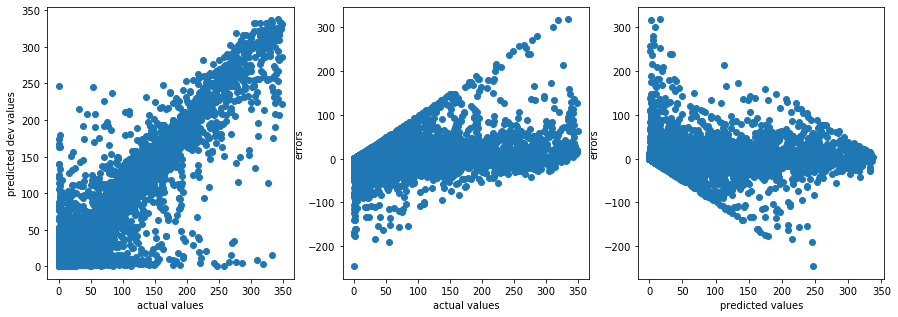

In [114]:
eval_model(y_dev[dev_cut], preds_1, y_train[train_cut], preds_train)

In [100]:
rf_1.feature_importances_

array([0.67210838, 0.07395246, 0.05516709, 0.03093518, 0.03806603,
       0.06831566, 0.0614552 ])

In [101]:
np.argsort(rf_1.feature_importances_)[::-1]

array([0, 1, 5, 6, 2, 4, 3])

for those keeping score at home, that's epa, (big dropoff) humidity, ndvi, elevation, temperature, wind_y, wind_x

## + neighbors in space at t = 0 (this one did best on sept 2019 only)

In [38]:
X_train_neighbors = np.load("X_train_neighbors.npy")
X_dev_neighbors = np.load("X_dev_neighbors.npy")

In [10]:
new = np.concatenate((X_train_base[train_cut],X_train_neighbors[train_cut]), axis = 1)

In [44]:
rf_2 = RandomForestRegressor(n_estimators = 25)
rf_2.fit(X = new, y = y_train[train_cut])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=25,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [47]:
train_preds = rf_2.predict(new)
dev_preds = rf_2.predict(np.concatenate((X_dev_base[dev_cut], X_dev_neighbors[dev_cut]), axis =1))

Train MSE: 5.5928041914943245
Train MAE: 0.8936817438517498
Train R2: 0.9798080450188693
Dev MSE: 34.079727586166435
Dev MAE: 2.312775734920835
Dev R2: 0.8734137459718544


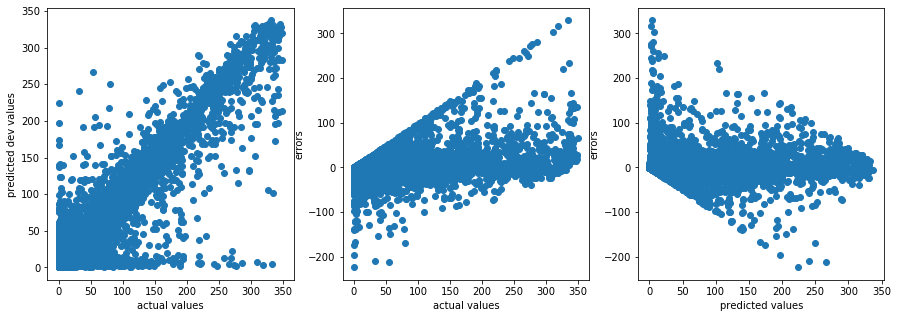

In [48]:
eval_model(y_dev[dev_cut], dev_preds, y_train[train_cut], train_preds)

In [11]:
rf_3 = RandomForestRegressor(n_estimators = 100, max_features = 'sqrt')
rf_3.fit(X = new, y = y_train[train_cut])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [12]:
train_preds = rf_3.predict(new)
dev_preds = rf_3.predict(np.concatenate((X_dev_base[dev_cut], X_dev_neighbors[dev_cut]), axis =1))

Train MSE: 4.842649028019952
Train MAE: 0.8482625125398314
Train R2: 0.9825163642753835
Dev MSE: 33.22355682164297
Dev MAE: 2.2543818063814185
Dev R2: 0.8765939195696455


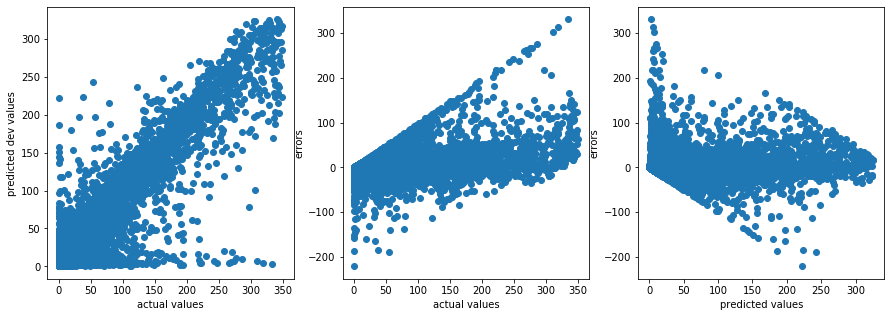

In [13]:
eval_model(y_dev[dev_cut], dev_preds, y_train[train_cut], train_preds)

In [36]:
feature_names = ['epa_pm25_value', 'humidity', 'temperature', 'wind_x', 'wind_y', 'ndvi', 'elevation'] + [f'neighbor_{m}' for m in range(0,24)]

In [39]:
fi = rf_3.feature_importances_
for f in np.argsort(rf_3.feature_importances_)[::-1]:
    print(feature_names[f], fi[f])

epa_pm25_value 0.5994267335786873
humidity 0.06084883789286311
ndvi 0.05121099889896335
temperature 0.05067800214405503
elevation 0.048090833149268285
wind_y 0.036019049310874275
wind_x 0.02929211964286956
neighbor_23 0.02254700576270408
neighbor_0 0.02066557754496286
neighbor_13 0.010888709985364226
neighbor_7 0.008821660422832825
neighbor_9 0.006822284510436933
neighbor_14 0.006213203419166636
neighbor_10 0.005727952658628729
neighbor_16 0.005562271845946313
neighbor_20 0.004432600969436216
neighbor_19 0.003960333927529572
neighbor_1 0.0030929885583891783
neighbor_11 0.002861508092519503
neighbor_2 0.002775433871930388
neighbor_3 0.0026546616473925137
neighbor_21 0.002606157865060363
neighbor_4 0.002459773246043322
neighbor_22 0.0024542080880804477
neighbor_6 0.0018760058849550808
neighbor_12 0.0018385536937837396
neighbor_15 0.0015933085376697747
neighbor_17 0.001575098893466523
neighbor_8 0.00128112286066242
neighbor_18 0.001111340990510139
neighbor_5 0.0006116621049471736


in order: epa_pm25_value, 'humidity', 'ndvi', 'temperature', 'elevation','wind_x', 'wind_y', then all the neighbor ones

In [15]:
from joblib import dump, load
dump(rf_3, '201901103_RF.joblib') 

['201901103_RF.joblib']

In [35]:
import subprocess
subprocess.run(f"/home/ubuntu/miniconda3/bin/aws s3 cp new_ndvi.tif s3://capstone-air-pollution/model_stuff/new_ndvi.tif", shell = True)

CompletedProcess(args='/home/ubuntu/miniconda3/bin/aws s3 cp new_ndvi.tif s3://capstone-air-pollution/model_stuff/new_ndvi.tif', returncode=0)

## + neighbors in space at t = 0 and t = -1 (has not been tried yet)

## + images

In [23]:
from sklearn.decomposition import PCA

In [26]:
pca = PCA(n_components = 100)
pca_train = pca.fit_transform(X_train_img[train_cut])

MemoryError: Unable to allocate array with shape (1907305, 4800) and data type float64